In [13]:
# Input info
se_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/SE.rds"
minCell = 1
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/clone_counts/minCellConds_1"
sample_names = "Control,Flt3l,Input"

# Parallel processing
cores = 4

# R utils script
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"



In [2]:
source(utils_script)
#source("/data/Mito_Trace/R_scripts/plot_de_over_all.R")

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
dir.create(outdir, showWarnings = TRUE)

Warning message in dir.create(outdir, showWarnings = TRUE):
“'/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/clone_counts/minCellConds_1' already exists”


In [14]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
sample_names

[1] "Control" "Flt3l"   "Input"

In [5]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")
library(dplyr)
library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package:

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [6]:
library(dplyr)

In [7]:
se <- readRDS(se_f)#file.path(indir, paste0("allSamples.integrated.rds")))
se

An object of class Seurat 
221404 features across 18672 samples within 2 assays 
Active assay: RNA (19039 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

# Get clones with mininum  cells in each condition and run DE pre and post

In [8]:
source(utils_script)
tmp = get.clone.sizes(se)
counts.norm=tmp[["counts.norm"]]
clone.sizes = tmp[["clone.size"]]
head(clone.sizes)

`summarise()` has grouped output by 'condition', 'donor', 'lineage'. You can override using the `.groups` argument.
Warning message in xtfrm.data.frame(x):
"cannot xtfrm data frames"
`summarise()` has grouped output by 'donor'. You can override using the `.groups` argument.


donor,lineage,norm.total,total,name,cdf.norm,cdf,index
<fct>,<fct>,<dbl>,<int>,<fct>,<dbl>,<int>,<int>
0,2,0.1387682,384,0_2,0.0693841,384,1
0,0,0.1355208,404,0_0,0.1371445,788,2
0,1,0.1348689,410,0_1,0.2045790,1198,3
0,3,0.1178096,342,0_3,0.2634837,1540,4
0,4,0.1044266,293,0_4,0.3156970,1833,5
0,6,0.1038769,304,0_6,0.3676355,2137,6


In [9]:
counts.norm

condition,donor,lineage,name,size,total,norm
<fct>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>
Flt3l,1,0,1_0,257,2947,0.08720733
Input,1,7,1_7,221,2537,0.08711076
Flt3l,1,5,1_5,250,2947,0.08483203
Control,1,1,1_1,203,2495,0.08136273
Input,0,1,0_1,274,3413,0.08028128
Input,1,6,1_6,200,2537,0.07883327
Control,1,3,1_3,195,2495,0.07815631
Input,1,1,1_1,197,2537,0.07765077
Flt3l,1,10,1_10,218,2947,0.07397353


In [10]:
curr.counts.norm = counts.norm[counts.norm$size>minCell,]
tmp.thresh = curr.counts.norm %>% group_by(name) %>% mutate(size=n())
curr.counts.norm = curr.counts.norm[tmp.thresh$size > 1, ]
curr.counts.norm = curr.counts.norm[order(curr.counts.norm$name),]
topClones = unique(curr.counts.norm$name)
#curr.counts.norm

In [11]:
sum(curr.counts.norm$norm)

[1] 5.994643

## Save

In [15]:
out.curr.counts.norm = tidyr::pivot_wider(curr.counts.norm, id_cols="name",values_from="norm", names_from="condition")
out.curr.counts.norm$size.mean = rowMeans(out.curr.counts.norm %>% dplyr::select(dplyr::all_of(sample_names)))
out.curr.counts.norm$fold =  out.curr.counts.norm[[sample_names[1]]]/out.curr.counts.norm[[sample_names[2]]]
#out.curr.counts.norm = out.curr.counts.norm %>% arrange(desc(size.mean)) %>% dplyr::select(-c(size.mean))
out.curr.counts.norm = out.curr.counts.norm %>% arrange(desc(fold))  %>% dplyr::select(-c(size.mean))
ord.inds = as.character(out.curr.counts.norm[["name"]])
out.curr.counts.norm



name,Input,Control,Flt3l,fold
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1_12,0.063460780,0.031663327,0.0095011876,3.332565
0_50,NA,0.001532959,0.0006079027,2.521717
1_11,0.047299961,0.046893788,0.0193417034,2.424491
1_1,0.077650769,0.081362725,0.0342721412,2.374019
1_6,0.078833268,0.033266533,0.0159484221,2.085882
1_7,0.087110761,0.026052104,0.0125551408,2.075015
0_19,0.041019631,0.013796627,0.0066869301,2.063223
1_3,0.056759953,0.078156313,0.0386834069,2.020409
0_13,0.054790507,0.019928462,0.0106382979,1.873275


In [16]:
out.curr.counts = tidyr::pivot_wider(curr.counts.norm, id_cols="name",values_from="total", names_from="condition")
out.curr.counts = as.data.frame(out.curr.counts)
row.names(out.curr.counts) = out.curr.counts$name
out.curr.counts = out.curr.counts[ord.inds,]
out.curr.counts

,name,Input,Control,Flt3l
,<fct>,<int>,<int>,<int>
1_12,1_12,2537,2495,2947
0_50,0_50,NA,1957,3290
1_11,1_11,2537,2495,2947
1_1,1_1,2537,2495,2947
1_6,1_6,2537,2495,2947
1_7,1_7,2537,2495,2947
0_19,0_19,3413,1957,3290
1_3,1_3,2537,2495,2947
0_13,0_13,3413,1957,3290


In [17]:
readr::write_csv(out.curr.counts.norm, file.path(outdir, "clone_sizes_norm.csv"))
readr::write_csv(out.curr.counts, file.path(outdir, "clone_sizes.csv"))

In [18]:
outdir

[1] "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/clone_counts/minCellConds_1"

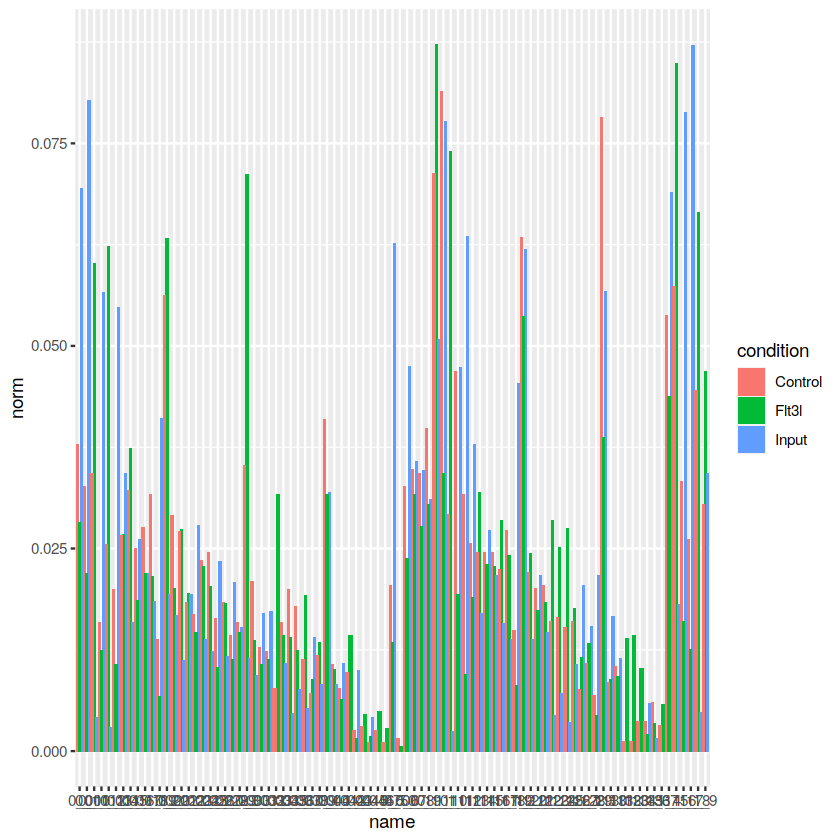

In [19]:
ggplot(data=curr.counts.norm, aes(x=name,y=norm, fill = condition)) + 
        geom_col(position='dodge') 
    

#ggsave(file.path(outdir, "topClonesSize_NormBatch.pdf"))

Saving 6.67 x 6.67 in image



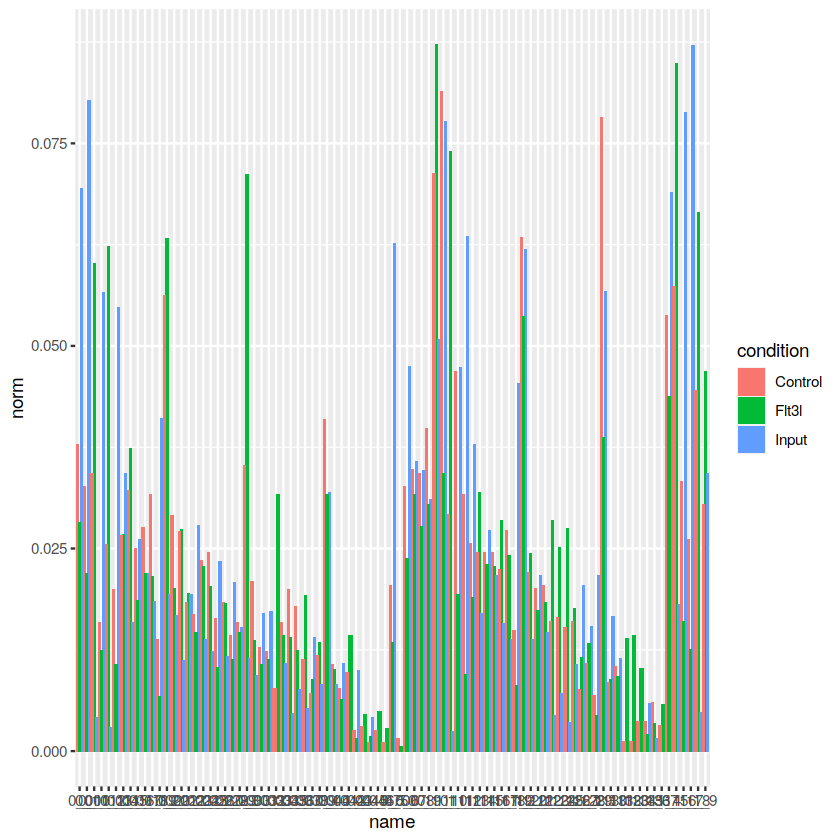

In [20]:
ggplot(data=curr.counts.norm, aes(x=name,y=norm, fill = condition)) + 
        geom_col(position='dodge') 
    

ggsave(file.path(outdir, "topClonesSize_NormBatch.pdf"))

Saving 6.67 x 6.67 in image



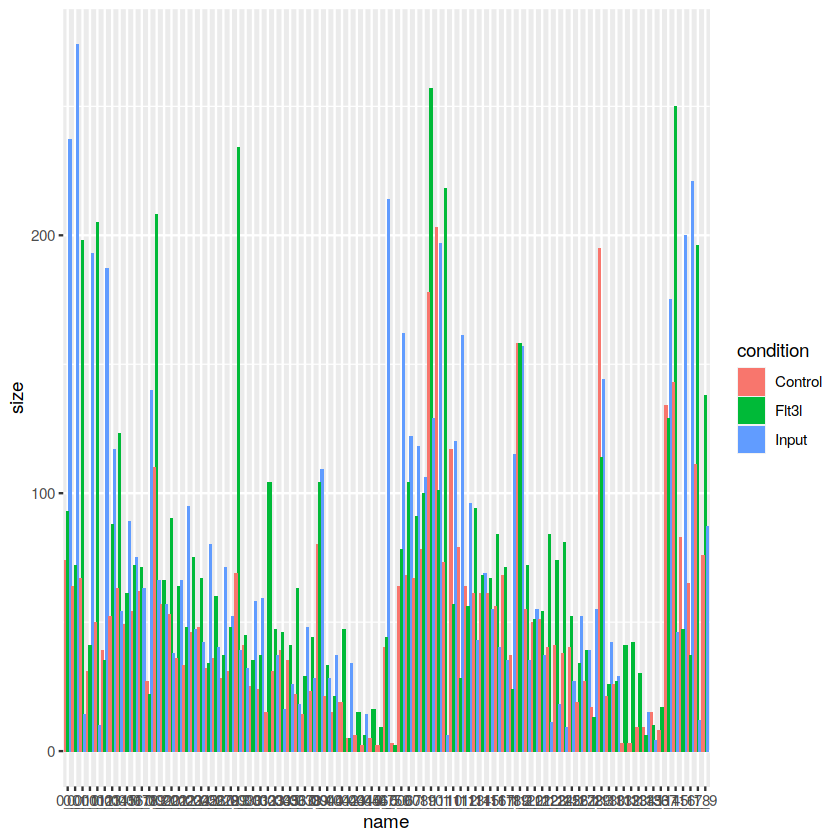

In [21]:
ggplot(data=curr.counts.norm, aes(x=name,y=size, fill = condition)) + 
        geom_col(position='dodge') 
    

ggsave(file.path(outdir, "topClonesSize.pdf"))

In [16]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.23.0             RColorBrewer_1.1-2       
 [3] metap_1.1                 cowplot_1.1.1            
 [5] magrittr_2.0.1            data.table_1.14.2        
 [7] patchwork_1.1.1           ggplot2_3.3.5            
 [9] EnsDb.Hsapiens.v75_2.99.0 ensembldb_2.18.1         
[11] 

In [17]:
outdir

[1] "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/clone_counts/minCellConds_1"